In [3]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [4]:
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script> so much code! click <a href="javascript:code_toggle()">here</a>.''')

In [5]:
import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np
import scipy as sp
import pandas as pd
import seawater
import datetime as dt
""
from salishsea_tools import (
    nc_tools,
    viz_tools,
    geo_tools,
    tidetools
)

import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import matplotlib.patches as patches
plt.style.use('seaborn-whitegrid')
import netCDF4 as nc
import pickle
import cmocean as cm
import glob
import sys
sys.path.append('/data/tjarniko/mocsy')
import mocsy

#from matplotlib import reload
import arrow
import gsw
import time

%matplotlib inline

plt.rcParams.update({'font.size': 20,
                     'xtick.labelsize' : 20,
                     'ytick.labelsize' : 20})



In [6]:

import BC_helper_methods as hm
import importlib
importlib.reload(hm)

<module 'BC_helper_methods' from '/ocean/tjarniko/MEOPAR/analysis_tereza/notebooks/RIVER_PAPER/future_pilot/INITIALIZATION/BC_helper_methods.py'>

In [7]:
# def co2_from_year(scen,tyear):
#     import pandas as pd
#     import numpy as np

#     #get witnessed co2, currently only takes 2-4.5 and 5-8.5

#     df = pd.read_csv('./meinshausen/meinshausen_scenario_conc.csv')
#     data_top = list(df.columns) 
# #     print('available data columns')
# #     print(data_top)

#     year = np.array(df['year'][:])
#     # SSP1_1pt9_NH = np.array(df['SSP1-1.9_NH'][:])
#     # SSP1_2pt6_NH = np.array(df['SSP1-2.6_NH'][:])
#     # SSP2_4pt5_NH = np.array(df['SSP2-4.5'][:])
#     SSP2_4pt5_NH = np.array(df['SSP2-4.5'][:])
#     SSP5_8pt5_NH = np.array(df['SSP5-8.5'][:])

#     q = np.shape(tyear)
#     tco2_ar = np.zeros_like(tyear)
#     tyear_r = np.ravel(tyear)
#     tco2_ar_r = np.ravel(tco2_ar)
#     for i in range(0,len(tco2_ar_r)):
#         # building for 2_4pt5
#         if (scen == '2_4pt5'): 

#             tco2_ar_r[i] = SSP2_4pt5_NH[year == (int(tyear_r[i]))]

#         if scen == '5_8pt5':

#             tco2_ar_r[i] = SSP5_8pt5_NH[year == (int(tyear_r[i]))]
    
#     #tco2_ar = tco2_ar_r.reshape(q[0],q[1])

#     return tco2_ar

In [8]:
print('warlurs')

warlurs


In [14]:
obs_year = [2015]
target_year = [2050]
scen = '2_4pt5'
DIC = 1800
TA = 2190
T = 7
S = 31


def Pacella_TCO2_PI(obs_year,target_year, scen, tsal, ttemp, dic, ta, verbose = False):
    

    watermass_witnessed_co2_obs = int(hm.co2_from_year_pointmeas(scen,obs_year))
    watermass_witnessed_co2_target = 280
    
    if verbose:
        print(f'obs year: {obs_year}')
        print(f'obs year co2: {watermass_witnessed_co2_obs}')
        print(f'target year: {target_year}')
        print(f'target year co2: {watermass_witnessed_co2_target}')
    
    DIC_obs_eq = hm.find_DIC_corresp_to_pco2(tsal, ttemp, watermass_witnessed_co2_obs, ta, 1, 0)
    del_TCO2 = dic - DIC_obs_eq
    
    DIC_target_eq = hm.find_DIC_corresp_to_pco2(tsal, ttemp, watermass_witnessed_co2_target, ta, 1, 0)
    DIC_target_final = DIC_target_eq + del_TCO2
    DIC_intrusion = DIC_target_final-dic
    #DIC_obs_real = hm.find_DIC_corresp_to_pco2(tsal, ttemp, watermass_witnessed_co2_obs, tta, 1, 0)
    if verbose:
        print('')
        #print(del_TCO2)
        print(f'this is what DIC would be at equilibrium (obs): {DIC_obs_eq}')
        print(f'this is what DIC actually is (obs): {dic}')
        print(f'this is the del TCO2: {del_TCO2}')
        print(f'this is what DIC would be at equilibrium (target): {DIC_target_eq}')
        print(f'this is what DIC actually should/would be (target): {DIC_target_eq + del_TCO2}')
        print(f'this is the intrusion: {DIC_intrusion}')
        
    #print(f'this is the intrusion: {DIC_intrusion}')
    return DIC_intrusion

Pacella_TCO2_PI(obs_year,target_year, scen, S, T, DIC, TA, verbose = True)



obs year: [2015]
obs year co2: 401
target year: [2050]
target year co2: 280

this is what DIC would be at equilibrium (obs): 2055.4799999995957
this is what DIC actually is (obs): 1800
this is the del TCO2: -255.47999999959575
this is what DIC would be at equilibrium (target): 2000.939999999611
this is what DIC actually should/would be (target): 1745.4600000000153
this is the intrusion: -54.53999999998473


-54.53999999998473

In [10]:
def calc_surface_intrusion_Pacella_method(arrowdate, obs_year, target_year, scen):
    import numpy as np
    import netCDF4 as nc
    import gsw
    
    test_LO = hm.load_nc(arrowdate)
    
    tdate = arrowdate
    yy = tdate.format('YYYY')
    mm = tdate.format('MM')
    dd = tdate.format('DD')
    ymd = f'y{yy}m{mm}d{dd}'
    #open dataset & retrieve relevant variables, calculate potential density

    #get just the surface intrusion
    zlevels = (test_LO['deptht'][:])
    sal = test_LO['vosaline'][0,0,0,:]
    temp = test_LO['votemper'][0,0,0,:]
    sigma0 = gsw.sigma0(sal,temp)
    DIC = test_LO['DIC'][0,0,0,:]
    TA = test_LO['TA'][0,0,0,:]
    
    intrusion = 0
    start = time.time()

    print(np.shape(DIC))
    #hardcode size of array 
    i = 450
    intrusion = Pacella_TCO2_PI(obs_year, target_year, scen, sal[i], temp[i], DIC[i], TA[i], verbose = False)
    print('seconds taken at the hard part')
    print(time.time()-start)
    
    return intrusion
    
#     f = nc.Dataset(f'./JdF_future_DIC/LO_TY_{target_year}_scen_{scen}_{ymd}_DIC_PacellaSurf.nc','w', format='NETCDF4') #'w' stands for write
#     g = f.createGroup('preindustrial_DIC')
#     g.createDimension('xval', 950)
#     g.createDimension('depth', 1)

#     ts = g.createVariable('DIC_intrusion','f4',('depth','xval'))
#     ts[:] = intrusion

#     f.close()

2015-01-01T00:00:00+00:00
(950,)
seconds taken at the hard part
0.08319878578186035
2015-01-02T00:00:00+00:00
(950,)
seconds taken at the hard part
0.0838615894317627
2015-01-03T00:00:00+00:00
(950,)
seconds taken at the hard part
0.08302021026611328
2015-01-04T00:00:00+00:00
(950,)
seconds taken at the hard part
0.0834352970123291
2015-01-05T00:00:00+00:00
(950,)
seconds taken at the hard part
0.08326220512390137
2015-01-06T00:00:00+00:00
(950,)
seconds taken at the hard part
0.09026122093200684
2015-01-07T00:00:00+00:00
(950,)
seconds taken at the hard part
0.08398580551147461
2015-01-08T00:00:00+00:00
(950,)
seconds taken at the hard part
0.08385229110717773
2015-01-09T00:00:00+00:00
(950,)
seconds taken at the hard part
0.08524489402770996
2015-01-10T00:00:00+00:00
(950,)
seconds taken at the hard part
0.08365893363952637
2015-01-11T00:00:00+00:00
(950,)
seconds taken at the hard part
0.0827324390411377
2015-01-12T00:00:00+00:00
(950,)
seconds taken at the hard part
0.0834538936614

(950,)
seconds taken at the hard part
0.0828096866607666
2015-04-11T00:00:00+00:00
(950,)
seconds taken at the hard part
0.08283233642578125
2015-04-12T00:00:00+00:00
(950,)
seconds taken at the hard part
0.08270001411437988
2015-04-13T00:00:00+00:00
(950,)
seconds taken at the hard part
0.08264803886413574
2015-04-14T00:00:00+00:00
(950,)
seconds taken at the hard part
0.08247971534729004
2015-04-15T00:00:00+00:00
(950,)
seconds taken at the hard part
0.08285284042358398
2015-04-16T00:00:00+00:00
(950,)
seconds taken at the hard part
0.08223676681518555
2015-04-17T00:00:00+00:00
(950,)
seconds taken at the hard part
0.08254265785217285
2015-04-18T00:00:00+00:00
(950,)
seconds taken at the hard part
0.08310127258300781
2015-04-19T00:00:00+00:00
(950,)
seconds taken at the hard part
0.08326077461242676
2015-04-20T00:00:00+00:00
(950,)
seconds taken at the hard part
0.08285188674926758
2015-04-21T00:00:00+00:00
(950,)
seconds taken at the hard part
0.08315443992614746
2015-04-22T00:00:00

(950,)
seconds taken at the hard part
0.09223079681396484
2015-07-20T00:00:00+00:00
(950,)
seconds taken at the hard part
0.08333778381347656
2015-07-21T00:00:00+00:00
(950,)
seconds taken at the hard part
0.08276605606079102
2015-07-22T00:00:00+00:00
(950,)
seconds taken at the hard part
0.08344674110412598
2015-07-23T00:00:00+00:00
(950,)
seconds taken at the hard part
0.08377504348754883
2015-07-24T00:00:00+00:00
(950,)
seconds taken at the hard part
0.08384943008422852
2015-07-25T00:00:00+00:00
(950,)
seconds taken at the hard part
0.0836172103881836
2015-07-26T00:00:00+00:00
(950,)
seconds taken at the hard part
0.08323121070861816
2015-07-27T00:00:00+00:00
(950,)
seconds taken at the hard part
0.08373546600341797
2015-07-28T00:00:00+00:00
(950,)
seconds taken at the hard part
0.08460450172424316
2015-07-29T00:00:00+00:00
(950,)
seconds taken at the hard part
0.08369946479797363
2015-07-30T00:00:00+00:00
(950,)
seconds taken at the hard part
0.0841829776763916
2015-07-31T00:00:00+

(950,)
seconds taken at the hard part
0.08515310287475586
2015-10-26T00:00:00+00:00
(950,)
seconds taken at the hard part
0.08236289024353027
2015-10-27T00:00:00+00:00
(950,)
seconds taken at the hard part
0.0826115608215332
2015-10-28T00:00:00+00:00
(950,)
seconds taken at the hard part
0.0833747386932373
2015-10-29T00:00:00+00:00
(950,)
seconds taken at the hard part
0.08359241485595703
2015-10-30T00:00:00+00:00
(950,)
seconds taken at the hard part
0.08323049545288086
2015-10-31T00:00:00+00:00
(950,)
seconds taken at the hard part
0.09222245216369629
2015-11-01T00:00:00+00:00
(950,)
seconds taken at the hard part
0.08410978317260742
2015-11-02T00:00:00+00:00
(950,)
seconds taken at the hard part
0.08315205574035645
2015-11-03T00:00:00+00:00
(950,)
seconds taken at the hard part
0.08318853378295898
2015-11-04T00:00:00+00:00
(950,)
seconds taken at the hard part
0.0830225944519043
2015-11-05T00:00:00+00:00
(950,)
seconds taken at the hard part
0.08353495597839355
2015-11-06T00:00:00+0

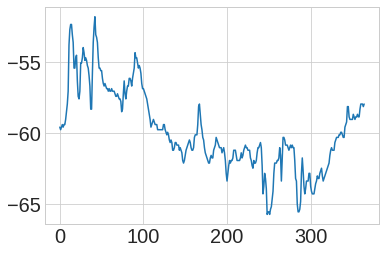

In [15]:
start ='2015-01-01'
end ='2015-12-31'

start_run = arrow.get(start)
end_run = arrow.get(end)

arrow_array = []

for r in arrow.Arrow.span_range('day', start_run, end_run):
    arrow_array.append(r)
    
intrs = np.zeros(365)
for i in range(0,365):
    intrusion = calc_surface_intrusion_Pacella_method(arrow_array[i][0], 2015, 2050, '2_4pt5')
    intrs[i] = intrusion
    
    


59.83495890409297

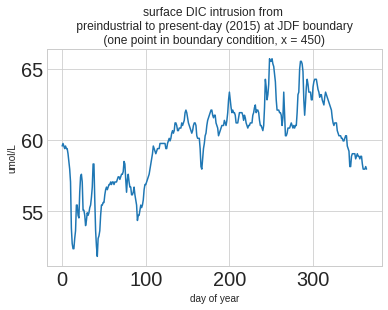

In [21]:
plt.plot(-intrs)
plt.ylabel('umol/L')
plt.title('surface DIC intrusion from \n preindustrial to present-day (2015) at JDF boundary \n (one point in boundary condition, x = 450) ')
plt.xlabel('day of year')
np.nanmean(-intrs)

In [12]:
from multiprocessing import Process

start ='2017-01-01'
end ='2017-12-31'

start_run = arrow.get(start)
end_run = arrow.get(end)

arrow_array = []

for r in arrow.Arrow.span_range('day', start_run, end_run):
    arrow_array.append(r)
    
    
def func1():
  print('func1: starting')
  for i in range(0,60):
        calc_surface_intrusion_Pacella_method(arrow_array[i][0], 2017, 2050, '2_4pt5')

def func2():
  print('func2: starting')
  for i in range(60,120):
        calc_surface_intrusion_Pacella_method(arrow_array[i][0], 2017, 2050, '2_4pt5')
      
def func3():
  print('func3: starting')
  for i in range(120,180):
        calc_surface_intrusion_Pacella_method(arrow_array[i][0], 2017, 2050, '2_4pt5')
        
def func4():
  print('func4: starting')
  for i in range(180,240):
        calc_surface_intrusion_Pacella_method(arrow_array[i][0], 2017, 2050, '2_4pt5')
        
def func5():
  print('func5: starting')
  for i in range(240,300):
        calc_surface_intrusion_Pacella_method(arrow_array[i][0], 2017, 2050, '2_4pt5')
        
def func6():
  print('func36: starting')
  for i in range(300,366):
        calc_surface_intrusion_Pacella_method(arrow_array[i][0], 2017, 2050, '2_4pt5')
        
if __name__ == '__main__':
  p1 = Process(target=func1)
  p1.start()
  p2 = Process(target=func2)
  p2.start()
  p3 = Process(target=func3)
  p3.start()
  p4 = Process(target=func4)
  p4.start()
  p5 = Process(target=func5)
  p5.start()
  p6 = Process(target=func6)
  p6.start()                
    
  p1.join()
  p2.join()
  p3.join()
  p4.join()
  p5.join()
  p6.join()

func1: starting
2017-01-01T00:00:00+00:00
func2: starting
2017-03-02T00:00:00+00:00
func3: starting
2017-05-01T00:00:00+00:00
func4: starting
2017-06-30T00:00:00+00:00
func5: starting
2017-08-29T00:00:00+00:00
func36: starting
2017-10-28T00:00:00+00:00
(950,)
(950,)
(950,)
(950,)
(950,)
(950,)
seconds taken at the hard part
0.09653520584106445
2017-01-02T00:00:00+00:00
seconds taken at the hard part
0.09535551071166992
2017-03-03T00:00:00+00:00
(950,)
seconds taken at the hard part
0.0954124927520752
2017-05-02T00:00:00+00:00
seconds taken at the hard part
0.09973549842834473
2017-10-29T00:00:00+00:00
seconds taken at the hard part
0.09689474105834961
2017-08-30T00:00:00+00:00
seconds taken at the hard part
0.09652853012084961
2017-07-01T00:00:00+00:00
(950,)
seconds taken at the hard part
0.09673166275024414
2017-01-03T00:00:00+00:00
(950,)
(950,)
(950,)
(950,)
seconds taken at the hard part
0.10026192665100098
2017-08-31T00:00:00+00:00
(950,)
seconds taken at the hard part
0.09203839

0.08789730072021484
2017-09-16T00:00:00+00:00
seconds taken at the hard part
0.0935518741607666
2017-03-18T00:00:00+00:00
(950,)
seconds taken at the hard part
0.09067177772521973
2017-11-14T00:00:00+00:00
seconds taken at the hard part
seconds taken at the hard part
0.08662176132202148
0.09140491485595703
2017-05-18T00:00:00+00:00
2017-07-17T00:00:00+00:00
(950,)
(950,)
(950,)
(950,)
(950,)
seconds taken at the hard part
0.09134507179260254
2017-01-16T00:00:00+00:00
seconds taken at the hard part
0.08926916122436523
2017-09-17T00:00:00+00:00
seconds taken at the hard part
0.09042525291442871
2017-11-15T00:00:00+00:00
(950,)
seconds taken at the hard part
0.09814071655273438
2017-03-19T00:00:00+00:00
seconds taken at the hard part
0.08965587615966797
seconds taken at the hard part
2017-05-19T00:00:00+00:00
0.09078145027160645
2017-07-18T00:00:00+00:00
(950,)
(950,)
(950,)
(950,)
(950,)
seconds taken at the hard part
0.09232378005981445
2017-01-17T00:00:00+00:00
seconds taken at the har

0.09221553802490234
2017-08-02T00:00:00+00:00
seconds taken at the hard part
(950,)
0.0896916389465332
2017-06-04T00:00:00+00:00
seconds taken at the hard part
seconds taken at the hard part
0.09188413619995117
0.0922858715057373
2017-12-01T00:00:00+00:00
2017-04-03T00:00:00+00:00
seconds taken at the hard part
seconds taken at the hard part
0.08858704566955566
0.0907297134399414
2017-10-03T00:00:00+00:00
2017-01-31T00:00:00+00:00
(950,)
(950,)
(950,)
seconds taken at the hard part
0.09250378608703613
2017-08-03T00:00:00+00:00
(950,)
(950,)
(950,)
seconds taken at the hard part
0.09003067016601562
2017-06-05T00:00:00+00:00
seconds taken at the hard part
0.0915682315826416
2017-12-02T00:00:00+00:00
(950,)
seconds taken at the hard part
0.0932614803314209
2017-04-04T00:00:00+00:00
seconds taken at the hard part
0.08930516242980957
2017-10-04T00:00:00+00:00
(950,)
(950,)
seconds taken at the hard part
0.0906820297241211
2017-02-01T00:00:00+00:00
(950,)
seconds taken at the hard part
0.092

0.09051156044006348
2017-12-17T00:00:00+00:00
seconds taken at the hard part
0.0892801284790039
2017-06-21T00:00:00+00:00
seconds taken at the hard part
0.09499287605285645
2017-02-14T00:00:00+00:00
seconds taken at the hard part
0.08944940567016602
2017-10-20T00:00:00+00:00
(950,)
(950,)
(950,)
seconds taken at the hard part
0.0912468433380127
2017-08-19T00:00:00+00:00
(950,)
(950,)
(950,)
seconds taken at the hard part
0.09067797660827637
2017-04-20T00:00:00+00:00
seconds taken at the hard part
0.09037590026855469
2017-12-18T00:00:00+00:00
seconds taken at the hard part
0.08909821510314941
2017-06-22T00:00:00+00:00
(950,)
seconds taken at the hard part
0.08739638328552246
2017-10-21T00:00:00+00:00
seconds taken at the hard part
0.09020042419433594
2017-02-15T00:00:00+00:00
(950,)
(950,)
seconds taken at the hard part
0.09141969680786133
2017-08-20T00:00:00+00:00
(950,)
(950,)
(950,)
seconds taken at the hard part
0.09138870239257812
2017-04-21T00:00:00+00:00
seconds taken at the hard

Process Process-6:
Traceback (most recent call last):
  File "/home/tjarniko/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/tjarniko/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-12-b8f06fe7b19e>", line 43, in func6
    calc_surface_intrusion_Pacella_method(arrow_array[i][0], 2017, 2050, '2_4pt5')
IndexError: list index out of range


seconds taken at the hard part
0.09109020233154297
2017-02-26T00:00:00+00:00
(950,)
seconds taken at the hard part
0.08548760414123535
2017-02-27T00:00:00+00:00
(950,)
seconds taken at the hard part
0.08564877510070801
2017-02-28T00:00:00+00:00
(950,)
seconds taken at the hard part
0.08541560173034668
2017-03-01T00:00:00+00:00
(950,)
seconds taken at the hard part
0.08572053909301758


In [13]:
def deltaDIC_method()

SyntaxError: invalid syntax (<ipython-input-13-49a9c3d84a4c>, line 1)

In [ ]:
w = nc.Dataset('./JdF_future_DIC/LO_TY_2050_scen_2_4pt5_y2017m01d01_DIC_nosurfnodeep.nc')
print(w['preindustrial_DIC'])

In [ ]:
tcmap = cm.cm.deep
cmap = tcmap
test_LO = nc.Dataset('/results/forcing/LiveOcean/boundary_conditions/LiveOcean_v201905_y2018m01d01.nc')
zlevels = (test_LO['deptht'][:])

fig = plt.figure(figsize=(11,3.5))

ax = fig.add_subplot(1,5,1)
section_slice = np.arange(0, 95)
sd = (w['preindustrial_DIC']['sigma0'][:,0:95])
tplt = np.ma.masked_values(sd,0)
mesh = ax.pcolormesh(section_slice[:],zlevels[:],tplt[:,:], cmap = tcmap)
cbar = fig.colorbar(mesh, ax=ax)
ax.invert_yaxis()
plt.title('sigma0') 
ax.set_ylabel('depth')
ax.set_xticklabels([])

ax = fig.add_subplot(1,5,2)
section_slice = np.arange(0, 95)
sd = (w['preindustrial_DIC']['water_age'][:,0:95])
tplt = np.ma.masked_values(sd,0)
mesh = ax.pcolormesh(section_slice[:],zlevels[:],tplt[:,:], cmap = tcmap)
cbar = fig.colorbar(mesh, ax=ax)
ax.invert_yaxis()
plt.title('water_age') 
ax.set_ylabel('depth')
ax.set_xticklabels([])


ax = fig.add_subplot(1,5,3)
section_slice = np.arange(0, 95)
sd = (w['preindustrial_DIC']['AOU_stoich'][:,0:95])
tplt = np.ma.masked_values(sd,0)
mesh = ax.pcolormesh(section_slice[:],zlevels[:],tplt[:,:], cmap = tcmap)
cbar = fig.colorbar(mesh, ax=ax)
ax.invert_yaxis()
plt.title('stoichiometric AOU') 
ax.set_ylabel('depth')
ax.set_xticklabels([])

ax = fig.add_subplot(1,5,4)
section_slice = np.arange(0, 95)
sd = (w['preindustrial_DIC']['final_target_DIC'][:,0:95])
tplt = np.ma.masked_values(sd,0)
mesh = ax.pcolormesh(section_slice[:],zlevels[:],tplt[:,:], cmap = tcmap)
cbar = fig.colorbar(mesh, ax=ax)
ax.invert_yaxis()
plt.title('final target DIC') 
ax.set_ylabel('depth')
ax.set_xticklabels([])


ax = fig.add_subplot(1,5,5)
section_slice = np.arange(0, 95)
sd = (w['preindustrial_DIC']['targetyear_pref_dic'][:,0:95]-\
     w['preindustrial_DIC']['obsyear_pref_dic'][:,0:95])
tplt = np.ma.masked_values(sd,0)
mesh = ax.pcolormesh(section_slice[:],zlevels[:],tplt[:,:], cmap = tcmap)
cbar = fig.colorbar(mesh, ax=ax)
ax.invert_yaxis()
plt.title('DIC intrusion yr 2050') 
ax.set_ylabel('depth')
ax.set_xticklabels([])
        
plt.suptitle('y2015m01d01 - basic parameters and extra DIC, year 2050, SSP245 ', fontsize = 15)
plt.tight_layout()

In [ ]:
q = w['preindustrial_DIC']['AOU_stoich'][:,0:95]
print(q)